# Overview

The objective of this notebook is to explore the possibility of using CNN to approximate the back projection from reflectivity curve (R-Q) to the SLD curve, which should provide the thickness of each layer.

## Execution plan

1. Use fixed layer structure with varied thickness to generate reflectivity curve as training data.
2. Use the trained CNN to predict the thickness of each layer from reflectivity curve.

## Generate training data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from refl1d.names import (
    Experiment,
    SLD,
    Slab,
    QProbe,
    Parameter,
)

### Define the sample

In [2]:
sample_layers = [
    {"sld":2.07, "isld":0, "thickness":0, "roughness":11.1, "name":"substrate"},
    {"sld":7.5, "isld":0, "thickness":25, "roughness":4, "name":"bulk"},
    {"sld":5, "isld":0, "thickness":200, "roughness":15, "name":"oxide"},
    {"sld":0, "isld":0, "thickness":0, "roughness":0, "name":"air"},
]

# build the sample
sample = Slab(
    material=SLD(
        name=sample_layers[0]["name"],
        rho=sample_layers[0]["sld"],
        irho=sample_layers[0]["isld"],
    ),
    thickness=sample_layers[0]["thickness"],
    interface=sample_layers[0]["roughness"],
)

for layer in sample_layers[1:]:
    sample = sample | Slab(
        material=SLD(
            name=layer["name"],
            rho=layer["sld"],
            irho=layer["isld"],
        ),
        thickness=layer["thickness"],
        interface=layer["roughness"],
    )


### Define the probe

In [3]:
q_range = np.logspace(
    np.log10(0.009),
    np.log10(0.18),
    num=150,
)

q_resolution = 0.025

dq = q_resolution * q_range / 2.355

zeros = np.zeros_like(q_range)

probe = QProbe(q_range, dq, data=(zeros, zeros))
probe.background = Parameter(value=0.0, name="background")

### Define the experiment

In [4]:
expt = Experiment(probe=probe, sample=sample)

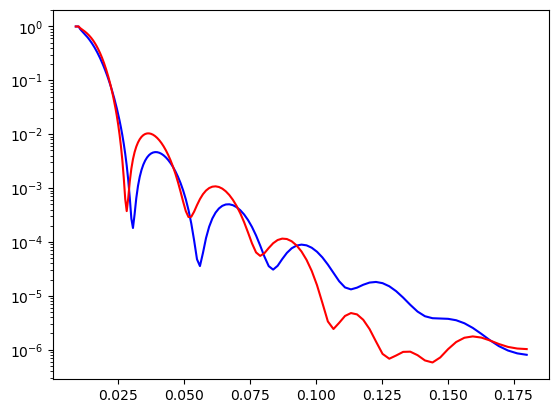

In [5]:
# quick test
q, r = expt.reflectivity()

plt.plot(q, r, 'b')
plt.yscale("log")

expt.sample[1].thickness.value = 50.0
expt.update()
q, r = expt.reflectivity()
plt.plot(q, r, 'r')


In [6]:
r.shape

(150,)

### Prepare training and testing data

Vary the thickness and roughness of bulk and oxide layer while keeping others fixed.

- bulk: sample[1]
  - thickness: [50, 500]
  - roughness: [20, 50]
- oxide: sample[2]
  - thickness: range [50, 300]
  - roughness: range [10, 150]


In [7]:
N_train = 80_000
N_test = 20_000
N_total = N_train + N_test

bulk_thickness = np.random.uniform(50, 500, size=N_total)
bulk_roughness = np.random.uniform(20, 50, size=N_total)
oxide_thickness = np.random.uniform(50, 300, size=N_total)
oxide_roughness = np.random.uniform(10, 150, size=N_total)

# stack the parameters
references = np.stack(
    [
        bulk_thickness,
        bulk_roughness,
        oxide_thickness,
        oxide_roughness,
    ],
    axis=1,
)

references.shape

(100000, 4)

In [8]:
r_curves = []
for i in tqdm(range(N_total)):
    expt.sample[1].thickness.value = bulk_thickness[i]
    expt.sample[1].interface.value = bulk_roughness[i]
    expt.sample[2].thickness.value = oxide_thickness[i]
    expt.sample[2].interface.value = oxide_roughness[i]
    expt.update()
    q, r = expt.reflectivity()
    r_curves.append(r)

r_curves = np.array(r_curves)

100%|██████████| 100000/100000 [00:08<00:00, 11214.91it/s]


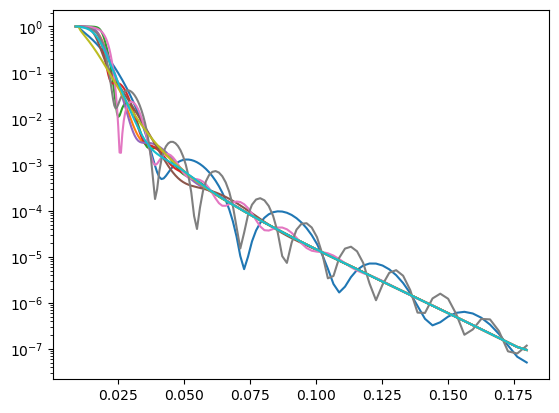

In [9]:
# plot the first 10 r-curves
for i in range(10):
    plt.plot(q, r_curves[i])
plt.yscale("log")

## Design network

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class ParamNet(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(150*150, 150*150*2)
        self.fc2 = nn.Linear(150*150*2, 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.outer(x, x).flatten()
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
seeker = ParamNet()

In [13]:
# covert to torch tensors
data_train = torch.tensor(r_curves[:N_train], dtype=torch.float32)
data_test = torch.tensor(r_curves[N_train:], dtype=torch.float32)

y_train = torch.tensor(references[:N_train], dtype=torch.float32)
y_test = torch.tensor(references[N_train:], dtype=torch.float32)

In [14]:
# quick test with a single r-curve
seeker(data_train[0])

tensor([-0.0342, -0.0094,  0.0315, -0.0379], grad_fn=<AddBackward0>)

the model is too big to fix on a m1 pro GPU

In [17]:
# move to m1's GPU
mps_device = torch.device("mps")

seeker.to(mps_device)

# move the data to the GPU
data_train = data_train.to(mps_device)
data_test = data_test.to(mps_device)

y_train = y_train.to(mps_device)
y_test = y_test.to(mps_device)

In [18]:
# quick test
seeker(data_train[1])

tensor([ 0.2109,  0.2030, -0.1426,  0.0045], device='mps:0',
       grad_fn=<LinearBackward0>)

## Training

In [15]:
# loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.Adam(seeker.parameters(), lr=1e-3)

In [16]:
# training loop
training_history = []
testing_history = []

for epoch in tqdm(range(200)):
    # training
    seeker.train()
    training_loss = 0.0
    for data, y in zip(data_train, y_train):
        optimizer.zero_grad()
        y_pred = seeker(data)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    training_loss /= len(data_train)
    training_history.append(training_loss)

    # testing
    seeker.eval()
    testing_loss = 0.0
    with torch.no_grad():
        for data, y in zip(data_test, y_test):
            y_pred = seeker(data)
            loss = loss_fn(y_pred, y_test)
            testing_loss += loss.item()
    testing_loss /= len(data_test)
    testing_history.append(testing_loss)

    # status update
    # if epoch % 10 == 0:
    print(f"epoch: {epoch}, training loss: {training_loss}, testing loss: {testing_loss}")

  0%|          | 0/200 [00:00<?, ?it/s]

## Evaluation